In [1]:
from axikernels.core.handlers import element_output
from axikernels.core.kernels import objective_function, kernel
from axikernels.aux import mesher
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Sensitivity kernel based on 1D backgroun Earth model

In this notebook we will compute a simple P wave sensitivity kernel (banana doughnut).

## Run forward simulation 

The first step is to set up a forward simulation with element output:

1. We use an already existing mesh sutable for 50s period simulations based on the prem ani model (global_mesh__prem_ani__50s.e). 
2. For the inparam.nr.yaml we just need to make sure to use a constant nr=5 in the whole domain since we are doing a 1D simulation (this is where the speed-up happens compared to other full 3D wave solvers).
3. For the source we can use whatever we like. In this case I used an explosion source. 
4. Finally, in the inparam.output.yaml we will put 1 element group for the mantle. Even though the simulation runs using 16 GLL points on each element, we will output only 9 to save some disk space. 
5. Run axisem3d (the size of the output file will be about 17GB! And the duration is about 0.4 cpu hours on a high end cpu. Maximum RAM usage is about 8GB. Make sure you have sufficient overhead for memory and disk.)

After running the simulation, we create an ElementOutput object to hold the simulation information.

In [2]:
forward_simulation = element_output.ElementOutput(path_to_element_output='data/EXAMPLE_FORWARD_iso/output/elements')

## Run Backward simulation

The next step depends on what kind of objective function we want to find the kernels to. The most popoular objective function is:
$$
\chi = \frac{1}{2}\mathcal{T}^2
$$
where $\mathcal{T}$ is the cross-correlation time shift between some observed (based on the real or a synthetic earth model $m$) displacement $\bm{u}(m;\bm{r}_0,t)$ and the forward displacement $\bm{u}_0(m_0;\bm{r}_0,t)$ at the same revciever location $\bm{r}_0$ (computed at the reference Earth $m_0$). We will use this objective as well:

In [3]:
time_shift_objective = objective_function.XObjectiveFunction(forward_simulation)

The backward field is computed over the same mesh as the forward field, the only difference is the source, which for the backward simulation is given by:
$$
f^{\dagger} = \frac{\mathcal{T} W[\dot{\bm{u}}] }{\left| W[\dot{\bm{u}}] \right|^2_2}
$$
Here $\dot{\bm{u}}$ is the time derivative of the forward displacement field evaluated at the location of the receiver. $W$ is the operator that representS "time windowing", which is needed if we want to isolate a certain phase. Mathematically, the backward field would be computed by solving the same wave equation as for the forward simulation but backwards in time and with $f^{\dagger}$ replacing the earthquake source. 

The *.compute_backward_field()* method of our XObjectiveFunction instance will:
1. Create a new simulation directory for the backward simulation 
2. Create an adjoint source and save it in the input directory of the backward simulation directory as three STF functions.

This method needs the following inputs:
1. Time shift $\mathcal{T}$ in seconds
2. The location of the reciever (in form [radius, latitude, longitude]) in meters and degrees.
3. Left and right time limits (in seconds) of the window containing the desired phase 

In this case we will isolate a P wave 

In [4]:
receiver_point = [6371000, 0, 50]
window = [585, 635]

In [5]:
%matplotlib inline
time_shift_objective.compute_backward_field(tau=2, receiver_point=receiver_point,
                                             window=window, cores=16, channel = 'UZ')

In [6]:
backward_simulation = element_output.ElementOutput(path_to_element_output='data/backward_EXAMPLE_FORWARD_iso/output/elements')

In [7]:
ker = kernel.Kernel(forward_simulation, backward_simulation)

Loading and interpolating: 100%|██████████| 18376/18376 [00:01<00:00, 14781.23point/s]
/disks/data/PhD/AxiSEM3D_Kernels/axikernels/core/kernels/kernel.py:1045: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  metadata.to_hdf(filename + '.h5', key='metadata', mode='a')


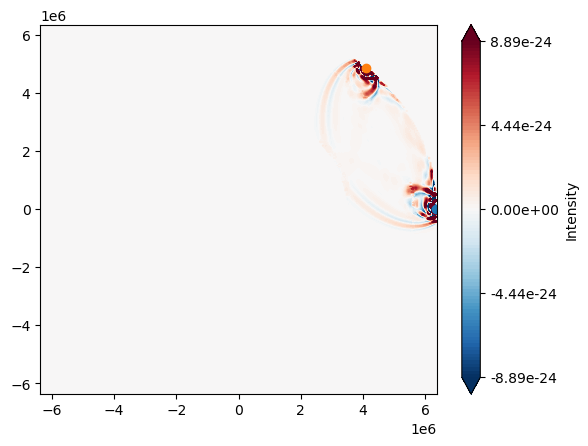

In [12]:
source_location = [forward_simulation.Domain_Radius - forward_simulation.source_depth,
                    forward_simulation.source_lat,
                    forward_simulation.source_lon]
receiver_point = [6371000, 0, np.deg2rad(50)]
parameter = 'vs'
x = ker.evaluate_on_slice(source_location=source_location,
                              station_location=receiver_point,
                              low_range=0, high_range=0.05, resolution=300,
                              domains=[[0, 6371000, -np.pi, np.pi]],
                              parameter=parameter, plot_data=True,
                              save_data=True, filename=parameter+'_PcP')

In [9]:
data_mesh = mesher.SliceMesh('vp_PcP.h5')

/disks/data/PhD/AxiSEM3D_Kernels/axikernels/aux/mesher.py:79: RuntimeWarning: invalid value encountered in scalar divide
  self.base2 /= np.linalg.norm(self.base2)


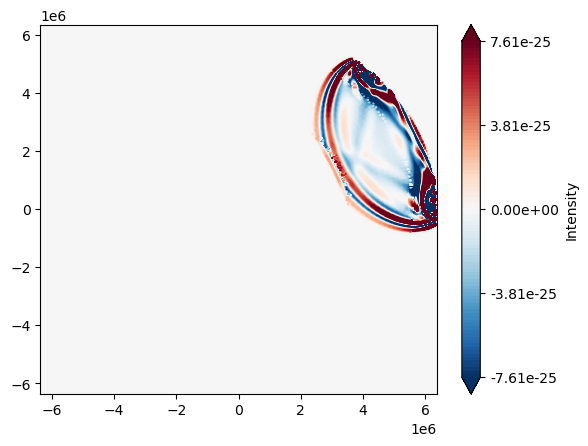

In [10]:
data_mesh.plot_on_mesh(high_range=0.05)

In [11]:
forward_simulation.obspyfy('/disks/data/PhD/AxiSEM3D_Kernels/examples/data/EXAMPLE_FORWARD_iso/input/STA_10DEG_GRID.txt', channels=['UR', 'UT', 'UZ'])

Loading and interpolating: 100%|██████████| 630/630 [00:00<00:00, 1514.52point/s]
/home/users/scro4564/anaconda3/envs/axikernels_test/lib/python3.12/site-packages/obspy/core/util/attribdict.py:199: UserWarning: Attribute "station" must be of type <class 'str'>, not <class 'int'>. Attempting to cast 38 to <class 'str'>
  warnings.warn(msg)
/home/users/scro4564/anaconda3/envs/axikernels_test/lib/python3.12/site-packages/obspy/core/util/attribdict.py:199: UserWarning: Attribute "station" must be of type <class 'str'>, not <class 'int'>. Attempting to cast 39 to <class 'str'>
  warnings.warn(msg)
/home/users/scro4564/anaconda3/envs/axikernels_test/lib/python3.12/site-packages/obspy/core/util/attribdict.py:199: UserWarning: Attribute "station" must be of type <class 'str'>, not <class 'int'>. Attempting to cast 40 to <class 'str'>
  warnings.warn(msg)
/home/users/scro4564/anaconda3/envs/axikernels_test/lib/python3.12/site-packages/obspy/core/util/attribdict.py:199: UserWarning: Attribute "s